In [361]:
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
import torch
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, Subset
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Import datasets

In [362]:
train_dataset = pd.read_csv("/Users/georg/Desktop/Projects/titanic/Titanic/train.csv")
test_dataset = pd.read_csv("/Users/georg/Desktop/Projects/titanic/Titanic/test.csv")

In [363]:
train_dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Baselines

##### Based on majority class

In [5]:
print("Survived: ", len(train_dataset.loc[train_dataset["Survived"] == 1]))
print("Died: ", len(train_dataset.loc[train_dataset["Survived"] == 0]))
print("Assign majority class: Everybody died (assign label 0 to every person in test set)")
print("Yielded accuracy: 0.622")

Survived:  342
Died:  549
Assign majority class: Everybody died (assign label 0 to every person in test set)
Yielded accuracy: 0.622


In [6]:
# # Write majority class prediction
# test_dataset["Survived"] = 0
# test_dataset_baseline_majority = test_dataset[['PassengerId', 'Survived']]
# test_dataset_baseline_majority.to_csv("./predictions/test_csv_baseline_majority.csv", index=False)

##### Based on feature classes

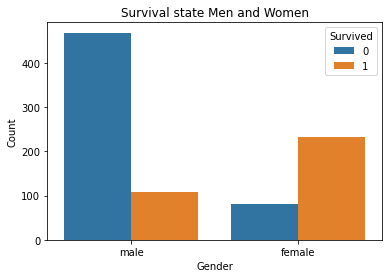

In [7]:
plt.figure(figsize=(6, 4))
sn.countplot(x=train_dataset["Sex"], hue=train_dataset["Survived"])
plt.title("Survival state Men and Women")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()
#plt.savefig("survival_men_woman.png")

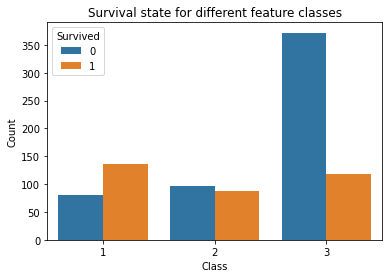

In [8]:
plt.figure(figsize=(6, 4))
sn.countplot(x=train_dataset["Pclass"], hue=train_dataset["Survived"])
plt.title("Survival state for different feature classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
#plt.savefig("survival_classes.png")

We can construct different feature classes for the passengers given their Sex and Class parameter value. We predict their survival according to the class they belong to:

- Male & 3rd class: 0
- Male & 2nd class: 0
- Male & 1st class: 0
- Female & 3rd class: 0
- Female & 2nd class: 1
- Female & 1st class: 1

In [9]:
print("Assign feature classes: Females in 2nd and 1st class survived, rest died")
print("Yielded accuracy: 0.77511")

Assign feature classes: Females in 2nd and 1st class survived, rest died
Yielded accuracy: 0.77511


In [10]:
# Write feature class prediction
# td_cl = test_dataset
# td_cl["Survived"] = 0
# td_cl.loc[(td_cl['Sex'] == "female") & (td_cl['Pclass'] == 2), 'Survived'] = 1
# td_cl.loc[(td_cl['Sex'] == "female") & (td_cl['Pclass'] == 1), 'Survived'] = 1
# td_cl = td_cl[['PassengerId', 'Survived']]
# td_cl.to_csv("./predictions/test_csv_feature_classes.csv", index=False)

##### Excursion: Principal Component Analysis

In [11]:
train_pca = train_dataset.copy()
train_pca.loc[train_pca["Sex"] == "female", "Sex"] = 1
train_pca.loc[train_pca["Sex"] == "male", "Sex"] = 0
train_pca = train_pca[["Pclass", "Sex", "Age", "Parch", "Fare"]]
train_pca = train_pca.dropna()
train_pca

,Pclass,Sex,Age,Parch,Fare
0,3,0,22.0,0,7.2500
1,1,1,38.0,0,71.2833
2,3,1,26.0,0,7.9250
3,1,1,35.0,0,53.1000
4,3,0,35.0,0,8.0500
...,...,...,...,...,...
885,3,1,39.0,5,29.1250
886,2,0,27.0,0,13.0000
887,1,1,19.0,0,30.0000
889,1,0,26.0,0,30.0000


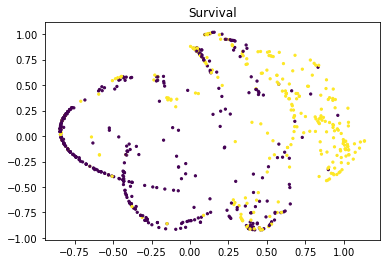

In [12]:
# PCA
pca = PCA(n_components=2)
preprocessed_train = preprocessing.normalize(preprocessing.scale(train_pca))
#missing feature scaling and normalization
pca.fit(preprocessed_train)
trans = pca.transform(preprocessed_train)
# Plotting
trdf = train_dataset[train_dataset['Age'].notna()]
plt.scatter(trans[:,0], trans[:,1], s=5, c=trdf['Survived'])
plt.title("Survival")
plt.show()

## Linear regression

In [167]:
def copy_dataframe(copy_from: pd.DataFrame):
    # Return copy of given data frame
    return copy_from.copy()

def bin_age(df: pd.DataFrame):
    # Assign categories to age
    bins = [0, 5, 17, 25, 50, 80]
    labels = [0, 5, 17, 25, 50]
    df['Age'] = pd.cut(df['Age'], bins = bins, labels = labels)
    df[['Age']] = df[['Age']].fillna(value=0)
    return df

def binarize_sex(df: pd.DataFrame):
    # Redefine Sex
    df.loc[df["Sex"] == "female", "Sex"] = 1
    df.loc[df["Sex"] == "male", "Sex"] = 0
    return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [169]:
# Provide training set
X = copy_dataframe(train_dataset)
X = bin_age(X) 
X = binarize_sex(X)

# Remove unecessary columns for training
X.drop(['Ticket', 'Cabin', 'Embarked', 'Name', 'PassengerId', 'Fare'],axis=1,inplace=True)
y = X['Survived'] #trying to predict
X.drop('Survived',axis=1,inplace=True)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train) # Train model
predictions = logmodel.predict(X_test) # Predict on held out test set for performance report

In [171]:
print("Performance on y_test:")
print(classification_report(y_test,predictions))

Performance on y_test:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82        51
           1       0.81      0.64      0.71        39

    accuracy                           0.78        90
   macro avg       0.78      0.76      0.77        90
weighted avg       0.78      0.78      0.77        90



In [172]:
# Adjust test set
test_data_logistic = copy_dataframe(test_dataset)
test_data_logistic = bin_age(test_data_logistic)
test_data_logistic = binarize_sex(test_data_logistic)
ids_logistic = test_data_logistic["PassengerId"] # truth

# Remove unnecessary columns for testing
test_data_logistic.drop(['Ticket', 'Cabin', 'Embarked', 'Name', 'PassengerId', "Fare"],axis=1,inplace=True)

# Predict on test set
predictions_test_data = logmodel.predict(test_data_logistic)
predictions_logistic = pd.DataFrame({"PassengerId":ids_logistic, "Survived": predictions_test_data})
# Write predictions
# predictions_logistic.to_csv("./predictions/test_csv_logistic.csv", index=False)

## Neural Network

In [566]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 270)
        self.fc2 = nn.Linear(270, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
net = Net()

In [567]:
X_train = train_ds.iloc[:, 1:6].values
X_train = X_train.astype(np.int32)
Y_train = train_ds.iloc[:, 0].values
Y_train = Y_train.astype(np.int32)

In [568]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [569]:
batch_size = 8
num_epochs = 50
learning_rate = 0.01
batch_no = len(x_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss = criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()

Epoch 1
Epoch 6
Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46


In [570]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x_val), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_val)
print('Accuracy {:.2f}'.format(num_right / len(y_val)))

Accuracy 0.80


In [571]:
X_test = test_ds.iloc[:, 0:6].values
X_test = X_test.astype(np.int32)
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=True)
X_test_var

tensor([[ 3.,  0., 25.,  0.,  0.],
        [ 3.,  1., 25.,  1.,  0.],
        [ 2.,  0., 50.,  0.,  0.],
        ...,
        [ 3.,  0., 25.,  0.,  0.],
        [ 3.,  0.,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  1.,  1.]], requires_grad=True)

In [572]:
# Applying model on the test data
with torch.no_grad():
    test_result = net(X_test_var)
values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()

In [573]:
mlp_output = pd.DataFrame({"PassengerId": test_dataset["PassengerId"], "Survived": survived})
#mlp_output.to_csv("./predictions/mlp_predictions.csv", index=False)